<a href="https://colab.research.google.com/github/SunnyChaturvedi/InnovationLabProject-CS299-/blob/main/DenominationDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 40kB/s 


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import ctypes
import itertools
import os


import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)


TF version: 2.4.0
Hub version: 0.10.0


In [6]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [8]:
data_dir = '/content/drive/MyDrive/dataset'

In [9]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 518 images belonging to 2 classes.
Found 2076 images belonging to 2 classes.


In [13]:
do_fine_tuning = False

In [14]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()


Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

Epoch 1/50
129/129 [==============================] - 179s 1s/step - loss: 0.5805 - accuracy: 0.7870 - val_loss: 0.4364 - val_accuracy: 0.8672
Epoch 2/50
129/129 [==============================] - 176s 1s/step - loss: 0.4655 - accuracy: 0.8389 - val_loss: 0.4326 - val_accuracy: 0.8691
Epoch 3/50
129/129 [==============================] - 175s 1s/step - loss: 0.4577 - accuracy: 0.8430 - val_loss: 0.4187 - val_accuracy: 0.8711
Epoch 4/50
129/129 [==============================] - 175s 1s/step - loss: 0.4293 - accuracy: 0.8680 - val_loss: 0.3981 - val_accuracy: 0.8867
Epoch 5/50
129/129 [==============================] - 176s 1s/step - loss: 0.4165 - accuracy: 0.8617 - val_loss: 0.4037 - val_accuracy: 0.8789
Epoch 6/50
129/129 [==============================] - 174s 1s/step - loss: 0.3884 - accuracy: 0.8843 - val_loss: 0.4326 - val_accuracy: 0.8652
Epoch 7/50
129/129 [==============================] - 176s 1s/step - loss: 0.3893 - accuracy: 0.8786 - val_loss: 0.3971 - val_accuracy: 0.8828

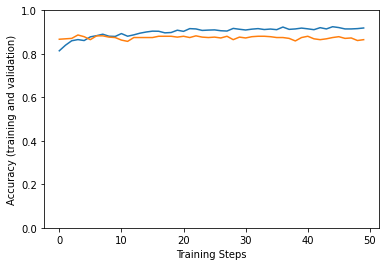

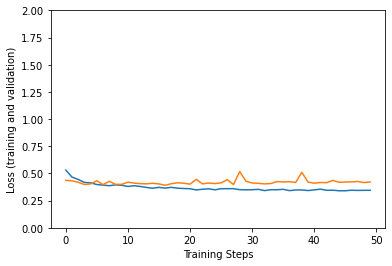

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history


plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

model.save('/content/drive/MyDrive/books/modelmobilenet2.h5')